### DeepLearning AUEB Course
#### Mouselinos Spyridon - Assignment 1
#### Fashion-MNIST
***

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

#### Upgrade Sci-Kit Learn
***

In [ ]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 22.3MB 1.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


### Imports

In [ ]:
### Deep Learning
import os
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed


### Arithmetic
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import top_k_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Visuals
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
np.random.seed(666) 
set_seed(666)

### Exersize Description

**Task**: Given an image of a clothing item classify its category

**Data**:
- The data are grayscale 28*28 images of clothes

**Approaches**
- According to the exersize the first approach would be to use MLP's (FFN) to classify the images.
- The second approach would be using a CNN for the same task.


**Preprocessing**
- Images will be normalized into a [0,1] or Zeta scale.
- The effect of image augmentations will be tested as well.



### Data Preprocessing
***

In [ ]:
def translate(item):
  __translation = {
      0:  'T-shirt/top',
      1:	'Trouser',
      2:	'Pullover',
      3:	'Dress',
      4:	'Coat',
      5:	'Sandal',
      6:	'Shirt',
      7:	'Sneaker',
      8:	'Bag',
      9:	'Ankle boot'
  }
  if isinstance(item, int):
    return __translation[item]
  elif isinstance(item, float):
    return __translation[int(item)]
  elif isinstance(item, str):
    return __translation[int(item)]
  else:
    raise ValueError("This Value is not a valid Index")
  return

In [ ]:
def get_data(normalization, validation_split):
  """
    Returns the Fashion-Mnist dataset without any augmentation.
  """
  classes = 10
  (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  if normalization == 'minmax':
    X_train /= 255
    X_test /= 255
  elif normalization == 'zeta':
    _mean = X_train.mean()
    _std = X_train.std()
    X_train = (X_train - _mean) / _std
    X_test = (X_test - _mean) / _std
  
  # Perform Stratified Split for Validation Set
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    stratify=y_train, 
                                                    test_size=validation_split, random_state=666)
  Y_train = to_categorical(y_train, classes)
  Y_val = to_categorical(y_val, classes)
  Y_test = to_categorical(y_test, classes)
  return X_train, Y_train, X_test, Y_test, X_val, Y_val

### Visualization of Data in MinMax
***

In [ ]:
_, _, Sample_Images, Sample_Labels, _, _ = get_data(normalization='minmax',validation_split=0.2)

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(Sample_Images[i].reshape((28,28))) 
    label_index = int(np.argmax(Sample_Labels[i]))
    plt.title(translate(label_index))
plt.show()

### Visualization of Data in Zeta
***

In [ ]:
_, _, Sample_Images, Sample_Labels, _, _ = get_data(normalization='zeta',validation_split=0.2)

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(Sample_Images[i].reshape((28,28))) 
    label_index = int(np.argmax(Sample_Labels[i]))
    plt.title(translate(label_index))
plt.show()

### Approach 1: FeedForward Network (MLP's)
***

In [ ]:
def create_ffn(name, hidden_layers, activation, dropout_rate, batchnorm_use, input_shape, classes, optimizer):
  """
    Creates a simple FFN
    //args
    name: The models name
    hidden_layers:     A list containing the units per layer.
    activation:        The type of activation between layers.
    dropout_rate:      A list containing the rate of dropout between layers.
    batchnorm_use:     A list containing whether to use BatchNormalization between layers.
  """
  image_input = Input(name='Image_Input_Layer', shape=input_shape)
  x = Flatten(name='Flattened_Image_Input')(image_input)

  for i, units in enumerate(hidden_layers):
      x = Dense(
          units=units,
          kernel_initializer='glorot_uniform',
          use_bias = not(batchnorm_use[i]), #Tip by Andrej Karpathy
          name='Hidden-{0:d}'.format(i + 1)
      )(x)
      if batchnorm_use[i]:
        x = BatchNormalization(name='BN-{0:d}'.format(i + 1))(x)
      
      x  = Activation(activation, name='Activation-{0:d}'.format(i + 1))(x)

      if dropout_rate[i] > 0:
        x = Dropout(rate=dropout_rate[i], name='Dropout-{0:d}'.format(i + 1))(x)


  # Define the output layer.
  output = Dense(
      units=classes,
      activation='softmax',
      name='Output'
  )(x)

  # Define the model and train it.
  model = Model(inputs=image_input, outputs=output)
  # Get Optimizer Configuration
  optimizer_name = optimizer['name']
  if optimizer_name == 'Adam':
    optimizer_cls = Adam(lr=optimizer['lr'])
  elif optimizer_name == 'SGD':
    optimizer_cls = SGD(learning_rate=optimizer['lr'], momentum=optimizer['momentum'])
  else:
    raise NotImplementedError("I have not included another optimizer yet :(\n")
  model.compile(optimizer=optimizer_cls, loss='categorical_crossentropy', metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=3)])
  return model

### Approach 2: Convolutional Neural Networks (CNN)
***

In [ ]:
def create_cnn(name, conv_layers, conv_activation, conv_dropout_rate, conv_batchnorm_use, pooling_layers,
               hidden_layers, hidden_activation, hidden_dropout_rate, hidden_batchnorm_use,
               input_shape, classes, optimizer, use_augmentation=False):
  """
    Creates a simple CNN
    //args
    name: The models name
    conv_layers:         A list containing the convolution characteristics per conv layer.
    conv_activation:     The type of activation between convolutional layers.
    conv_dropout_rate:   The type of dropout between convolutional layers.
    conv_batchnorm_use:  A list containing whether to use BatchNormalization between convolutional layers.
    pooling_layers       A list containing the poolling characteristics between conv layers.

    hidden_layers:       A list containing the units per hidden dense layer.
    hidden_activation:   The type of activation between hidden dense layers.
    dropout_rate:        A list containing the rate of dropout between hidden dense layers.
    batchnorm_use:       A list containing whether to use BatchNormalization between hidden dense layers.
    use_augmentation: Whether to use an augmentation layer in the network.
  """
  image_input = Input(name='Image_Input_Layer', shape=input_shape)

  if use_augmentation is False:
    # Do nothing
    x = image_input
  else:
    # Create a small augmentation network to build uppon
    x = RandomFlip("horizontal")(image_input) 
    x = RandomRotation(factor=0.02)(x) # -+ 7 degrees
    x = RandomZoom(height_factor=0.1, width_factor=0.1)(x) # -+ 10% Zoom in Both Directions

  #------------------------#
  ### Convolutional Part ###
  #------------------------#
  for i, configs in enumerate(conv_layers):
      x = Conv2D(
          filters = configs['filters'],
          kernel_size = configs['kernel_size'] if 'kernel_size' in configs else 3,
          strides = configs['strides'] if 'strides' in configs else (1,1),
          kernel_initializer='glorot_uniform',
          use_bias = not(conv_batchnorm_use[i]), #Tip by Andrej Karpathy
          name='Conv-{0:d}'.format(i + 1)
      )(x)
      if conv_batchnorm_use[i]:
        x = BatchNormalization(name='Conv-BN-{0:d}'.format(i + 1))(x)
      
      x  = Activation(conv_activation, name='Conv-Activation-{0:d}'.format(i + 1))(x)

      if conv_dropout_rate[i] > 0:
        x = Dropout(rate=conv_dropout_rate[i], name='Conv-Dropout-{0:d}'.format(i + 1))(x)

      if pooling_layers[i] is not None:
        config = pooling_layers[i]
        pooling_type = config['type']
        if pooling_type == 'max':
          x = MaxPooling2D(pool_size=config['pool_size'])(x)
        elif pooling_type == 'avg':
          x = AveragePooling2D(pool_size=config['pool_size'])(x)
        else:
          raise NotImplementedError("I have not included another Pooling Option :(\n")

  if len(hidden_layers) > 0:
    x = Flatten(name='Flatten_to_FFN')(x)

  #--------------#
  ### FFN Part ###
  #--------------#
  for i, units in enumerate(hidden_layers):
      x = Dense(
          units=units,
          kernel_initializer='glorot_uniform',
          use_bias = not(hidden_batchnorm_use[i]), #Tip by Andrej Karpathy
          name='Hidden-{0:d}'.format(i + 1)
      )(x)
      if hidden_batchnorm_use[i]:
        x = BatchNormalization(name='BN-{0:d}'.format(i + 1))(x)
      
      x  = Activation(hidden_activation, name='Activation-{0:d}'.format(i + 1))(x)

      if hidden_dropout_rate[i] > 0:
        x = Dropout(rate=hidden_dropout_rate[i], name='Dropout-{0:d}'.format(i + 1))(x)

  # Define the output layer.
  output = Dense(
      units=classes,
      activation='softmax',
      name='Output'
  )(x)

  # Define the model and train it.
  model = Model(inputs=image_input, outputs=output)
  # Get Optimizer Configuration
  optimizer_name = optimizer['name']

  if optimizer_name == 'Adam':
    optimizer_cls = Adam(learning_rate=optimizer['lr'])

  elif optimizer_name == 'SGD':
    optimizer_cls = SGD(learning_rate=optimizer['lr'], momentum=optimizer['momentum'])

  else:
    raise NotImplementedError("I have not included another optimizer yet :(\n")
  model.compile(optimizer=optimizer_cls, loss='categorical_crossentropy', metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=3)])
  return model

### Fitting A Model
***

In [ ]:
def fit_a_model(model, train_data, val_data):
  """
    Performs training of a Model on the Fashion Mnist data
    //args
    save: If true saves the model for future reference
  """
  
  es = EarlyStopping(
      monitor='val_categorical_accuracy',
      patience=15,
      verbose=1,
      restore_best_weights=True
  )

  rs = ReduceLROnPlateau(
      factor = 0.5,
      monitor='val_loss',
      patience=10,
      verbose=1,
      min_delta=0.001,
      min_lr = 1e-7
  )

  callbacks = [es,rs]
  history  =  model.fit(train_data[0],train_data[1], batch_size=256, epochs=300, validation_data=(val_data[0],val_data[1]), callbacks=callbacks, verbose=2)
  return history, model  

### Testing a Model

In [ ]:
def test_a_model(model, test_data):
  """
    Performs testing of a Model on the Fashion Mnist data
    //args
  """
  predictions = model.predict(test_data[0])
  real_targets = test_data[1]

  # Let's Calculate some Metrics of Interest
  # Accuracy
  accuracy = top_k_accuracy_score(np.argmax(real_targets, axis=1), predictions, k=1)

  # Top-3 Accuracy
  top3accuracy =  top_k_accuracy_score(np.argmax(real_targets, axis=1), predictions, k=3)

  #F1-score 
  f1 = f1_score(np.argmax(real_targets, axis=1), np.argmax(predictions, axis=1), average='weighted')

  return accuracy, top3accuracy, f1

### Plotting results

In [ ]:
def plot_history(hs, epochs, metric, save_folder):
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    n_labels = len(hs)
    for label in hs:
      if n_labels < 2:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
      else:
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 5))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend(loc=2, prop={'size': 10})
    plt.savefig(save_folder)
    plt.show()
    plt.close()

### Saving Result Metrics

In [ ]:
def save_results(results, save_folder):
  with open(save_folder, 'w') as fout:
    fout.write("Accuracy,Top3Accuracy,F1_weighted\n")
    fout.write(f"{results[0]},{results[1]},{results[2]}")
  return

### Run Architectural Experiments


In [ ]:
def run_architectural_experiments(result_folder, mode):
  """
    Runs all the experiments
    //args
    result_folder: The folder to store each model configurations results
    mode: 3 modes, (0: FFN only, 1: CNN only, 2: All)
  """
  try:
    os.mkdir(result_folder)
  except FileExistsError:
    pass
  ### FFN Configurations ###
  part_1_configurations = {
      'config_1':{
          'name':'Small_SGD_Drop',
          'hidden_layers':[100],
          'activation':'tanh',
          'dropout_rate':[0.2],
          'batchnorm_use':[False],
          'input_shape':(28,28),
          'classes':10,
          'optimizer': {'name':'SGD','lr':0.001,'momentum':0.0}
      },
      'config_2':{
          'name':'Small_Mom_SGD_Drop',
          'hidden_layers':[100],
          'activation':'tanh',
          'dropout_rate':[0.2],
          'batchnorm_use':[False],
          'input_shape':(28,28),
          'classes':10,
          'optimizer': {'name':'SGD','lr':0.001,'momentum':0.9}
      },
      'config_3':{
          'name':'Small_Adam_Drop',
          'hidden_layers':[100],
          'activation':'tanh',
          'dropout_rate':[0.2],
          'batchnorm_use':[False],
          'input_shape':(28,28),
          'classes':10,
          'optimizer': {'name':'Adam','lr':0.0005,'momentum':None}
      },
      'config_4':{
          'name':'Small_Adam_Relu_Drop',
          'hidden_layers':[100],
          'activation':'relu',
          'dropout_rate':[0.2],
          'batchnorm_use':[False],
          'input_shape':(28,28),
          'classes':10,
          'optimizer': {'name':'Adam','lr':0.0005,'momentum':None}
      },
      'config_5':{
          'name':'Medium_Adam_Relu_Drop',
          'hidden_layers':[200,200],
          'activation':'relu',
          'dropout_rate':[0.2,0.2],
          'batchnorm_use':[False,False],
          'input_shape':(28,28),
          'classes':10,
          'optimizer': {'name':'Adam','lr':0.0005,'momentum':None}
      },
      'config_6':{
          'name':'Medium_Adam_Relu_BN1_No_Drop',
          'hidden_layers':[200,200],
          'activation':'relu',
          'dropout_rate':[0.0,0.0],
          'batchnorm_use':[True,False],
          'input_shape':(28,28),
          'classes':10,
          'optimizer': {'name':'Adam','lr':0.0005,'momentum':None}
      },
      'config_7':{
          'name':'Medium_Adam_Relu_BN2_No_Drop',
          'hidden_layers':[200,200],
          'activation':'relu',
          'dropout_rate':[0.0,0.0],
          'batchnorm_use':[True,True],
          'input_shape':(28,28),
          'classes':10,
          'optimizer': {'name':'Adam','lr':0.0005,'momentum':None}
      },
      'config_8':{
          'name':'Large_Adam_Relu',
          'hidden_layers':[250,250,250],
          'activation':'relu',
          'dropout_rate':[0.4,0.4,0.4],
          'batchnorm_use':[False,False,False],
          'input_shape':(28,28),
          'classes':10,
          'optimizer': {'name':'Adam','lr':0.0005,'momentum':None}
      }
  }
  ### CNN Configurations ###
  part_2_configurations = {
      'config_1':{
          'name':'Small_Conv_Small_Dense_SGD_Mom',
          'conv_layers': [{'filters':32,'kernel_size':3}],
          'conv_activation':'relu',
          'conv_dropout_rate':[0.2],
          'pooling_layers': [{'type':'max', 'pool_size':(2,2)}],
          'conv_batchnorm_use':[False],

          'hidden_layers':[128],
          'hidden_activation':'relu',
          'hidden_dropout_rate':[0.2],
          'hidden_batchnorm_use':[False],
          
          'use_augmentation':False,
          'input_shape':(28,28,1),
          'classes':10,
          'optimizer': {'name':'SGD','lr':0.001,'momentum':0.9}
      },
      'config_2':{
          'name':'Small_Conv_Small_Dense_Adam',
          'conv_layers': [{'filters':32,'kernel_size':3}],
          'conv_activation':'relu',
          'conv_dropout_rate':[0.2],
          'pooling_layers': [{'type':'max', 'pool_size':(2,2)}],
          'conv_batchnorm_use':[False],

          'hidden_layers':[128],
          'hidden_activation':'relu',
          'hidden_dropout_rate':[0.2],
          'hidden_batchnorm_use':[False],
          
          'use_augmentation':False,
          'input_shape':(28,28,1),
          'classes':10,
          'optimizer': {'name':'Adam','lr':0.0005,'momentum':None}
      },
      'config_3':{
          'name':'Medium_Conv_Small_Dense_Adam',
          'conv_layers': [{'filters':32,'kernel_size':3},
                          {'filters':64,'kernel_size':3}],
          'conv_activation':'relu',
          'conv_dropout_rate':[0.2,0.2],
          'pooling_layers': [{'type':'max', 'pool_size':(2,2)},
                             {'type':'max', 'pool_size':(2,2)}],
          'conv_batchnorm_use':[False,False],

          'hidden_layers':[128],
          'hidden_activation':'relu',
          'hidden_dropout_rate':[0.2],
          'hidden_batchnorm_use':[False],
          
          'use_augmentation':False,
          'input_shape':(28,28,1),
          'classes':10,
          'optimizer': {'name':'Adam','lr':0.0005,'momentum':None}
      },
      'config_4':{
          'name':'Medium_Conv_Medium_Dense_Adam_Augment',
          'conv_layers': [{'filters':32,'kernel_size':3},
                          {'filters':64,'kernel_size':3}],
          'conv_activation':'relu',
          'conv_dropout_rate':[0.2,0.2],
          'pooling_layers': [{'type':'max', 'pool_size':(2,2)},
                             {'type':'max', 'pool_size':(2,2)}],
          'conv_batchnorm_use':[False,False],

          'hidden_layers':[128, 64],
          'hidden_activation':'relu',
          'hidden_dropout_rate':[0.2, 0.2],
          'hidden_batchnorm_use':[False,False],
          
          'use_augmentation':True,
          'input_shape':(28,28,1),
          'classes':10,
          'optimizer': {'name':'Adam','lr':0.0005,'momentum':None}
      },
      'config_5':{
          'name':'Large_Conv_Small_Dense_Adam_Augment',
          'conv_layers': [{'filters':32,'kernel_size':3},
                          {'filters':64,'kernel_size':3},
                          {'filters':128,'kernel_size':3}],
          'conv_activation':'relu',
          'conv_dropout_rate':[0.2,0.2,0.2],
          'pooling_layers': [{'type':'max', 'pool_size':(2,2)},
                             {'type':'max', 'pool_size':(2,2)},
                             {'type':'max', 'pool_size':(2,2)}],
          'conv_batchnorm_use':[False,False,False],

          'hidden_layers':[128],
          'hidden_activation':'relu',
          'hidden_dropout_rate':[0.2],
          'hidden_batchnorm_use':[False],
          
          'use_augmentation':True,
          'input_shape':(28,28,1),
          'classes':10,
          'optimizer': {'name':'Adam','lr':0.0005,'momentum':None}
      },
      'config_6':{
          'name':'Large_Conv_Medium_Dense_Adam_Augment',
          'conv_layers': [{'filters':32,'kernel_size':3},
                          {'filters':64,'kernel_size':3},
                          {'filters':128,'kernel_size':3}],
          'conv_activation':'relu',
          'conv_dropout_rate':[0.2,0.2,0.2],
          'pooling_layers': [{'type':'max', 'pool_size':(2,2)},
                             {'type':'max', 'pool_size':(2,2)},
                             {'type':'max', 'pool_size':(2,2)}],
          'conv_batchnorm_use':[False,False,False],

          'hidden_layers':[128, 64],
          'hidden_activation':'relu',
          'hidden_dropout_rate':[0.2, 0.2],
          'hidden_batchnorm_use':[False,False],
          
          'use_augmentation':True,
          'input_shape':(28,28,1),
          'classes':10,
          'optimizer': {'name':'Adam','lr':0.0005,'momentum':None}
      },
      'config_7':{
          'name':'Large_Conv_Small_Dense_Adam_BN_Augment',
          'conv_layers': [{'filters':32,'kernel_size':3},
                          {'filters':64,'kernel_size':3},
                          {'filters':128,'kernel_size':3}],
          'conv_activation':'relu',
          'conv_dropout_rate':[0.2,0.2,0.2],
          'pooling_layers': [{'type':'max', 'pool_size':(2,2)},
                             {'type':'max', 'pool_size':(2,2)},
                             {'type':'max', 'pool_size':(2,2)}],
          'conv_batchnorm_use':[True,True,True],

          'hidden_layers':[128],
          'hidden_activation':'relu',
          'hidden_dropout_rate':[0.2],
          'hidden_batchnorm_use':[False],
          
          'use_augmentation':True,
          'input_shape':(28,28,1),
          'classes':10,
          'optimizer': {'name':'Adam','lr':0.0005,'momentum':None}
      },
      'config_8':{
          'name':'Large_Conv_Medium_Dense_Adam_BN_Augment',
          'conv_layers': [{'filters':32,'kernel_size':3},
                          {'filters':64,'kernel_size':3},
                          {'filters':128,'kernel_size':3}],
          'conv_activation':'relu',
          'conv_dropout_rate':[0.2,0.2,0.2],
          'pooling_layers': [{'type':'max', 'pool_size':(2,2)},
                             {'type':'max', 'pool_size':(2,2)},
                             {'type':'max', 'pool_size':(2,2)}],
          'conv_batchnorm_use':[True,True,True],

          'hidden_layers':[128, 64],
          'hidden_activation':'relu',
          'hidden_dropout_rate':[0.2, 0.2],
          'hidden_batchnorm_use':[False,False],
          
          'use_augmentation':True,
          'input_shape':(28,28,1),
          'classes':10,
          'optimizer': {'name':'Adam','lr':0.0005,'momentum':None}
      }
  }
  if mode == 0:
    hs = {}
    result_tuples = []
    for experiment in part_1_configurations:
      config = part_1_configurations[experiment]
      print(f"Training {experiment}\n")
      try:
        os.mkdir(result_folder + f"/{config['name']}")
      except FileExistsError:
        pass
      model = create_ffn(**config)
      history, model = fit_a_model(model=model, train_data=(X_train,Y_train), val_data=(X_val, Y_val))
      plot_history(hs = {config['name']: history}, epochs=100, metric='loss', save_folder=result_folder + f"/{config['name']}/loss.png")
      plot_history(hs = {config['name']: history}, epochs=100, metric='categorical_accuracy', save_folder=result_folder + f"/{config['name']}/acc.png")
      plot_history(hs = {config['name']: history}, epochs=100, metric='top_k_categorical_accuracy', save_folder=result_folder + f"/{config['name']}/all_top_3_acc.png")
      
      results = test_a_model(model=model, test_data=(X_train,Y_train))
      save_results(results=results, save_folder=result_folder + f"/{config['name']}/train_stats.txt")
      
      results = test_a_model(model=model, test_data=(X_val,Y_val))
      save_results(results=results, save_folder=result_folder + f"/{config['name']}/val_stats.txt")

      results = test_a_model(model=model, test_data=(X_test,Y_test))
      save_results(results=results, save_folder=result_folder + f"/{config['name']}/test_stats.txt") 

      hs.update({config['name']: history})
      result_tuples.append(results)

    # Plot all of them together
    plot_history(hs = hs, epochs=100, metric='loss', save_folder=result_folder + '/all_losses.png')
    plot_history(hs = hs, epochs=100, metric='categorical_accuracy', save_folder=result_folder + '/all_acc.png')
    plot_history(hs = hs, epochs=100, metric='top_k_categorical_accuracy', save_folder=result_folder + '/all_top_3_acc.png')

    # Return top 3 configurations based on Accuracy
    top_3_keys = np.argsort(np.array(result_tuples,dtype='float')[:,0])[:-4:-1]
    top_3_configs = []
    for key in top_3_keys:
      top_3_configs.append(part_1_configurations[f'config_{key+1}'])
    return list(hs.keys()), result_tuples, top_3_configs

  elif mode == 1:
    hs = {}
    result_tuples = []
    for experiment in part_2_configurations:
      config = part_2_configurations[experiment]
      print(f"Training {experiment}\n")
      try:
        os.mkdir(result_folder + f"/{config['name']}")
      except FileExistsError:
        pass
      model = create_cnn(**config)
      X_train_r = np.expand_dims(X_train, axis=-1)
      X_test_r  = np.expand_dims(X_test,  axis=-1)
      history, model = fit_a_model(model=model, train_data=(X_train,Y_train), val_data=(X_val, Y_val))
      plot_history(hs = {config['name']: history}, epochs=100, metric='loss', save_folder=result_folder + f"/{config['name']}/loss.png")
      plot_history(hs = {config['name']: history}, epochs=100, metric='categorical_accuracy', save_folder=result_folder + f"/{config['name']}/acc.png")
      plot_history(hs = {config['name']: history}, epochs=100, metric='top_k_categorical_accuracy', save_folder=result_folder + f"/{config['name']}/all_top_3_acc.png")
      results = test_a_model(model=model, test_data=(X_train,Y_train))
      save_results(results=results, save_folder=result_folder + f"/{config['name']}/train_stats.txt")
      
      results = test_a_model(model=model, test_data=(X_val,Y_val))
      save_results(results=results, save_folder=result_folder + f"/{config['name']}/val_stats.txt")

      results = test_a_model(model=model, test_data=(X_test,Y_test))
      save_results(results=results, save_folder=result_folder + f"/{config['name']}/test_stats.txt") 
      hs.update({config['name']: history})
      result_tuples.append(results)

    # Plot all of them together
    plot_history(hs = hs, epochs=100, metric='loss', save_folder=result_folder + '/all_losses.png')
    plot_history(hs = hs, epochs=100, metric='categorical_accuracy', save_folder=result_folder + '/all_acc.png')
    plot_history(hs = hs, epochs=100, metric='top_k_categorical_accuracy', save_folder=result_folder + '/all_top_3_acc.png')

    # Return top 3 configurations based on Accuracy
    top_3_keys = np.argsort(np.array(result_tuples,dtype='float')[:,0])[:-4:-1]
    top_3_configs = []
    for key in top_3_keys:
      top_3_configs.append(part_2_configurations[f'config_{key+1}'])
    return list(hs.keys()), result_tuples, top_3_configs
  elif mode == 2:
    return [run_architectural_experiments(result_folder=result_folder,mode=0), run_architectural_experiments(result_folder=result_folder,mode=1)]

### Run Experiment  - Architecture Search MinMax

In [ ]:
X_train, Y_train, X_test, Y_test, X_val, Y_val = get_data(normalization='minmax',validation_split=0.2)

In [ ]:
ffn_results, cnn_results = run_architectural_experiments(result_folder='./results_minmax',mode=2)
ffn_experiments, ffn_result_tuples, top_3_ffn_configs = ffn_results
cnn_experiments, cnn_result_tuples, top_3_cnn_configs = cnn_results
ffn_results = pd.DataFrame(data=np.array(ffn_result_tuples,dtype='float'),columns=['Top 1 Accuracy', 'Top 3 Accuracy', 'F1 Weighted'], index=[ffn_experiments])
cnn_results = pd.DataFrame(data=np.array(cnn_result_tuples,dtype='float'),columns=['Top 1 Accuracy', 'Top 3 Accuracy', 'F1 Weighted'], index=[cnn_experiments])
combined_results = pd.concat([ffn_results,cnn_results],axis=0)
combined_results.to_csv("./results/Experiment_results_minmax.csv")

### Run Experiment  - Architecture Search Zeta

In [ ]:
X_train, Y_train, X_test, Y_test, X_val, Y_val = get_data(normalization='zeta',validation_split=0.2)

In [ ]:
ffn_results, cnn_results = run_architectural_experiments(result_folder='./results_zeta',mode=2)
ffn_experiments, ffn_result_tuples, top_3_ffn_configs = ffn_results
cnn_experiments, cnn_result_tuples, top_3_cnn_configs = cnn_results
ffn_results = pd.DataFrame(data=np.array(ffn_result_tuples,dtype='float'),columns=['Top 1 Accuracy', 'Top 3 Accuracy', 'F1 Weighted'], index=[ffn_experiments])
cnn_results = pd.DataFrame(data=np.array(cnn_result_tuples,dtype='float'),columns=['Top 1 Accuracy', 'Top 3 Accuracy', 'F1 Weighted'], index=[cnn_experiments])
combined_results = pd.concat([ffn_results,cnn_results],axis=0)
combined_results.to_csv("./results/Experiment_results_zeta.csv")

In [ ]:
# !cp "results" -r "drive/MyDrive/Msc_Asoe/final_results"

### Extra Tuning the top 2 best architectures
***

### The Best 2 architectures were:
 - Small_Conv_Small_Dense_Adam (CNN config)
 - Medium_Conv_Small_Dense_Adam (CNN config)

#### They achieved their best results at LR = 0.005, BS = 256, No augmentation.

 - `Idea 1`: Maybe the poor performance With Augmentation was due to the fact that the augmentation was heavy ( 18 deg rotation, -+ 20% zoom)

 - `Idea 2`: The Reduction Of LR on Plateu Was Used, maybe the performance with change with a decay factor.


In [ ]:
first_candidate_config = {
          'name':'Small_Conv_Small_Dense_Adam',
          'conv_layers': [{'filters':32,'kernel_size':3}],
          'conv_activation':'relu',
          'conv_dropout_rate':[0.2],
          'pooling_layers': [{'type':'max', 'pool_size':(2,2)}],
          'conv_batchnorm_use':[False],

          'hidden_layers':[128],
          'hidden_activation':'relu',
          'hidden_dropout_rate':[0.2],
          'hidden_batchnorm_use':[False],
          
          'use_augmentation':True, # Idea 1
          'input_shape':(28,28,1),
          'classes':10,
          'optimizer': {'name':'Adam','lr':0.0005,'momentum':None}
      }

second_candidate_config = {
          'name':'Medium_Conv_Small_Dense_Adam',
          'conv_layers': [{'filters':32,'kernel_size':3},
                          {'filters':64,'kernel_size':3}],
          'conv_activation':'relu',
          'conv_dropout_rate':[0.2,0.2],
          'pooling_layers': [{'type':'max', 'pool_size':(2,2)},
                             {'type':'max', 'pool_size':(2,2)}],
          'conv_batchnorm_use':[False,False],

          'hidden_layers':[128],
          'hidden_activation':'relu',
          'hidden_dropout_rate':[0.2],
          'hidden_batchnorm_use':[False],
          
          'use_augmentation':True, # Idea 1
          'input_shape':(28,28,1),
          'classes':10,
          'optimizer': {'name':'Adam','lr':0.0005,'momentum':None}
      }

In [ ]:
X_train, Y_train, X_test, Y_test, X_val, Y_val = get_data(normalization='minmax',validation_split=0.2)

4423680/4422102 [==============================] - 0s 0us/step


### Test Idea 1
***

In [ ]:
try:
  os.mkdir("./extra_experiments")
  os.mkdir("./extra_experiments/candidate_1")
except:
  pass
model_1 = create_cnn(**first_candidate_config)
X_train_r = np.expand_dims(X_train, axis=-1)
X_test_r  = np.expand_dims(X_test,  axis=-1)
history, model_1 = fit_a_model(model=model_1, train_data=(X_train,Y_train), val_data=(X_val, Y_val))
plot_history(hs = {'candidate_1': history}, epochs=300, metric='loss', save_folder="./extra_experiments/candidate_1/loss.png")
plot_history(hs = {'candidate_1': history}, epochs=300, metric='categorical_accuracy', save_folder="./extra_experiments/candidate_1/acc.png")
plot_history(hs = {'candidate_1': history}, epochs=300, metric='top_k_categorical_accuracy', save_folder="./extra_experiments/candidate_1/all_top_3_acc.png")
results = test_a_model(model=model_1, test_data=(X_train,Y_train))
save_results(results=results, save_folder="./extra_experiments/candidate_1/train_stats.txt")

results = test_a_model(model=model_1, test_data=(X_val,Y_val))
save_results(results=results, save_folder="./extra_experiments/candidate_1/val_stats.txt")

results = test_a_model(model=model_1, test_data=(X_test,Y_test))
save_results(results=results, save_folder="./extra_experiments/candidate_1/test_stats.txt") 

In [ ]:
try:
  os.mkdir("./extra_experiments/candidate_2")
except:
  pass
model_2 = create_cnn(**second_candidate_config)
X_train_r = np.expand_dims(X_train, axis=-1)
X_test_r  = np.expand_dims(X_test,  axis=-1)
history, model_2 = fit_a_model(model=model_2, train_data=(X_train,Y_train), val_data=(X_val, Y_val))
plot_history(hs = {'candidate_2': history}, epochs=300, metric='loss', save_folder="./extra_experiments/candidate_2/loss.png")
plot_history(hs = {'candidate_2': history}, epochs=300, metric='categorical_accuracy', save_folder="./extra_experiments/candidate_2/acc.png")
plot_history(hs = {'candidate_2': history}, epochs=300, metric='top_k_categorical_accuracy', save_folder="./extra_experiments/candidate_2/all_top_3_acc.png")
results = test_a_model(model=model_2, test_data=(X_train,Y_train))
save_results(results=results, save_folder="./extra_experiments/candidate_2/train_stats.txt")

results = test_a_model(model=model_2, test_data=(X_val,Y_val))
save_results(results=results, save_folder="./extra_experiments/candidate_2/val_stats.txt")

results = test_a_model(model=model_2, test_data=(X_test,Y_test))
save_results(results=results, save_folder="./extra_experiments/candidate_2/test_stats.txt") 

### Test Idea 2
***

In [ ]:
def decayed_learning_rate(step):
  return 0.005 * 0.98 ** (step / 50)

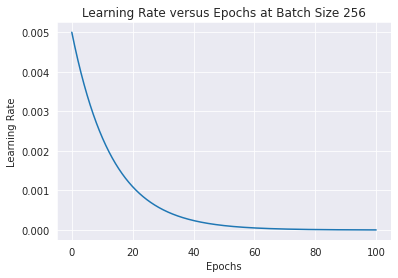

In [ ]:
plt.figure()
plt.title("Learning Rate versus Epochs at Batch Size 256")
plt.ylabel("Learning Rate")
plt.xlabel("Epochs")
plt.plot([f / 188 for f in range(0,188 * 100)], [decayed_learning_rate(f) for f in range(0,188 * 100)])
plt.show()

In [ ]:
decay = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps= 50,
    decay_rate=0.98,
    staircase=False)

first_candidate_config = {
          'name':'Small_Conv_Small_Dense_Adam',
          'conv_layers': [{'filters':32,'kernel_size':3}],
          'conv_activation':'relu',
          'conv_dropout_rate':[0.2],
          'pooling_layers': [{'type':'max', 'pool_size':(2,2)}],
          'conv_batchnorm_use':[False],

          'hidden_layers':[128],
          'hidden_activation':'relu',
          'hidden_dropout_rate':[0.2],
          'hidden_batchnorm_use':[False],
          
          'use_augmentation':False, # Idea 2
          'input_shape':(28,28,1),
          'classes':10,
          'optimizer': {'name':'Adam','lr':decay}
      }

second_candidate_config = {
          'name':'Medium_Conv_Small_Dense_Adam',
          'conv_layers': [{'filters':32,'kernel_size':3},
                          {'filters':64,'kernel_size':3}],
          'conv_activation':'relu',
          'conv_dropout_rate':[0.2,0.2],
          'pooling_layers': [{'type':'max', 'pool_size':(2,2)},
                             {'type':'max', 'pool_size':(2,2)}],
          'conv_batchnorm_use':[False,False],

          'hidden_layers':[128],
          'hidden_activation':'relu',
          'hidden_dropout_rate':[0.2],
          'hidden_batchnorm_use':[False],
          
          'use_augmentation':False, # Idea 2
          'input_shape':(28,28,1),
          'classes':10,
          'optimizer': {'name':'Adam','lr':decay}
      }

In [ ]:
def fit_a_model(model, train_data, val_data):
  """
    Performs training of a Model on the Fashion Mnist data
    //args
    save: If true saves the model for future reference
  """
  
  es = EarlyStopping(
      monitor='val_categorical_accuracy',
      patience=15,
      verbose=1,
      restore_best_weights=True
  )

  callbacks = [es]
  history  =  model.fit(train_data[0],train_data[1], batch_size=256, epochs=300, validation_data=(val_data[0],val_data[1]), callbacks=callbacks, verbose=2)
  return history, model  

Epoch 1/300
188/188 - 8s - loss: 0.4757 - categorical_accuracy: 0.8331 - top_k_categorical_accuracy: 0.9734 - val_loss: 0.3363 - val_categorical_accuracy: 0.8846 - val_top_k_categorical_accuracy: 0.9911
Epoch 2/300
188/188 - 1s - loss: 0.2987 - categorical_accuracy: 0.8912 - top_k_categorical_accuracy: 0.9909 - val_loss: 0.2846 - val_categorical_accuracy: 0.8965 - val_top_k_categorical_accuracy: 0.9921
Epoch 3/300
188/188 - 1s - loss: 0.2552 - categorical_accuracy: 0.9060 - top_k_categorical_accuracy: 0.9938 - val_loss: 0.2653 - val_categorical_accuracy: 0.9015 - val_top_k_categorical_accuracy: 0.9928
Epoch 4/300
188/188 - 1s - loss: 0.2237 - categorical_accuracy: 0.9181 - top_k_categorical_accuracy: 0.9956 - val_loss: 0.2557 - val_categorical_accuracy: 0.9051 - val_top_k_categorical_accuracy: 0.9936
Epoch 5/300
188/188 - 1s - loss: 0.2031 - categorical_accuracy: 0.9234 - top_k_categorical_accuracy: 0.9964 - val_loss: 0.2450 - val_categorical_accuracy: 0.9084 - val_top_k_categorical_ac

FileNotFoundError: ignored

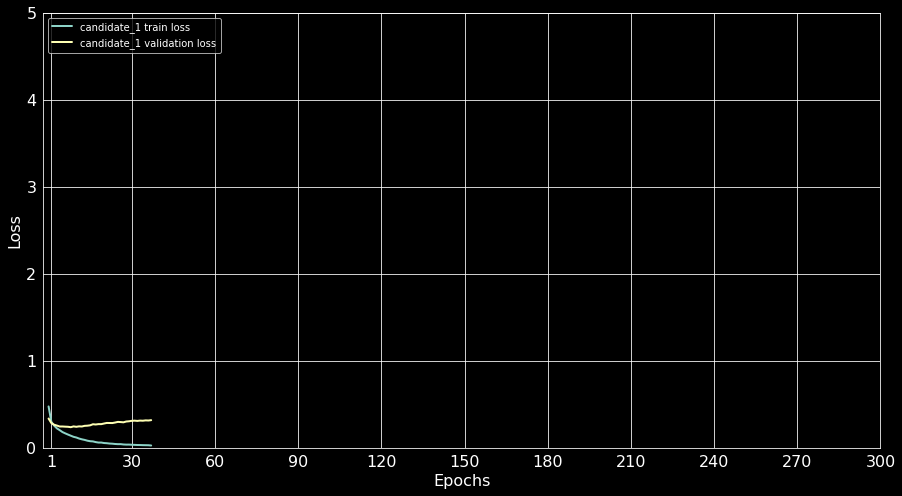

In [ ]:
try:
  os.mkdir("./extra_experiments/candidate_1_2")
except:
  pass
model_1 = create_cnn(**first_candidate_config)
X_train_r = np.expand_dims(X_train, axis=-1)
X_test_r  = np.expand_dims(X_test,  axis=-1)
history, model_1 = fit_a_model(model=model_1, train_data=(X_train,Y_train), val_data=(X_val, Y_val))
plot_history(hs = {'candidate_1': history}, epochs=300, metric='loss', save_folder="./extra_experiments/candidate_1_2/loss.png")
plot_history(hs = {'candidate_1': history}, epochs=300, metric='categorical_accuracy', save_folder="./extra_experiments/candidate_1_2/acc.png")
plot_history(hs = {'candidate_1': history}, epochs=300, metric='top_k_categorical_accuracy', save_folder="./extra_experiments/candidate_1_2/all_top_3_acc.png")
results = test_a_model(model=model_1, test_data=(X_train,Y_train))
save_results(results=results, save_folder="./extra_experiments/candidate_1_2/train_stats.txt")

results = test_a_model(model=model_1, test_data=(X_val,Y_val))
save_results(results=results, save_folder="./extra_experiments/candidate_1_2/val_stats.txt")

results = test_a_model(model=model_1, test_data=(X_test,Y_test))
save_results(results=results, save_folder="./extra_experiments/candidate_1_2/test_stats.txt") 

In [ ]:
try:
  os.mkdir("./extra_experiments/candidate_2_2")
except:
  pass
model_2 = create_cnn(**second_candidate_config)
X_train_r = np.expand_dims(X_train, axis=-1)
X_test_r  = np.expand_dims(X_test,  axis=-1)
history, model_2 = fit_a_model(model=model_2, train_data=(X_train,Y_train), val_data=(X_val, Y_val))
plot_history(hs = {'candidate_1': history}, epochs=300, metric='loss', save_folder="./extra_experiments/candidate_2_2/loss.png")
plot_history(hs = {'candidate_1': history}, epochs=300, metric='categorical_accuracy', save_folder="./extra_experiments/candidate_2_2/acc.png")
plot_history(hs = {'candidate_1': history}, epochs=300, metric='top_k_categorical_accuracy', save_folder="./extra_experiments/candidate_2_2/all_top_3_acc.png")
results = test_a_model(model=model_2, test_data=(X_train,Y_train))
save_results(results=results, save_folder="./extra_experiments/candidate_2_2/train_stats.txt")

results = test_a_model(model=model_2, test_data=(X_val,Y_val))
save_results(results=results, save_folder="./extra_experiments/candidate_2_2/val_stats.txt")

results = test_a_model(model=model_2, test_data=(X_test,Y_test))
save_results(results=results, save_folder="./extra_experiments/candidate_2_2/test_stats.txt") 

### Confusion Matrix
***

In [ ]:
predictions = model_1.predict(X_test)
prediction_labels = np.argmax(predictions,axis=1)
real_values = np.argmax(Y_test,axis=1)

[Text(0.5, 0, 'T-shirt/top'),
 Text(1.5, 0, 'Trouser'),
 Text(2.5, 0, 'Pullover'),
 Text(3.5, 0, 'Dress'),
 Text(4.5, 0, 'Coat'),
 Text(5.5, 0, 'Sandal'),
 Text(6.5, 0, 'Shirt'),
 Text(7.5, 0, 'Sneaker'),
 Text(8.5, 0, 'Bag'),
 Text(9.5, 0, 'Ankle boot')]

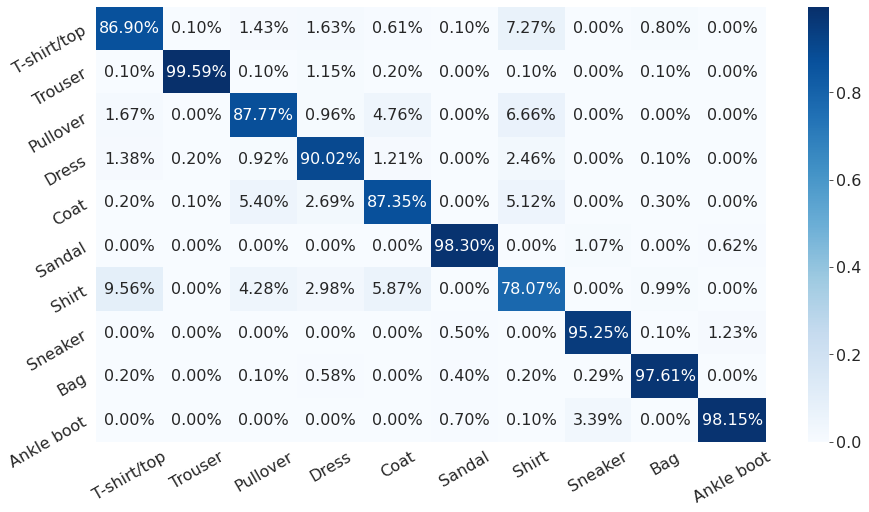

In [ ]:
cf_matrix = confusion_matrix(real_values, prediction_labels)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix,axis=0), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_yticklabels([translate(f) for f in range(0,10)], rotation=30) 
ax.set_xticklabels([translate(f) for f in range(0,10)], rotation=30) 

### Re-use Validation for fine Tuning for 10 Epochs (not in report)
***

In [ ]:
X_train_silver = np.vstack([X_train,X_val])
Y_train_silver = np.vstack([Y_train,Y_val])

In [ ]:
def fit_a_model(model, train_data, val_data):
  """
    Performs training of a Model on the Fashion Mnist data
    //args
    save: If true saves the model for future reference
  """
  model.compile(optimizer=SGD(learning_rate=1e-6, momentum=0.9), loss='categorical_crossentropy', metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=3)])
  history  =  model.fit(train_data[0],train_data[1], batch_size=256, epochs=10, verbose=2)
  return history, model  

In [ ]:
try:
  os.mkdir("./extra_experiments/candidate_1_3")
except:
  pass
history, model_1 = fit_a_model(model=model_1, train_data=(X_train_silver,Y_train_silver), val_data=None)
results = test_a_model(model=model_1, test_data=(X_train,Y_train))
save_results(results=results, save_folder="./extra_experiments/candidate_1_3/train_stats.txt")
results = test_a_model(model=model_1, test_data=(X_test,Y_test))
save_results(results=results, save_folder="./extra_experiments/candidate_1_3/test_stats.txt") 

In [ ]:
try:
  os.mkdir("./extra_experiments/candidate_2_3")
except:
  pass
history, model_2 = fit_a_model(model=model_2, train_data=(X_train_silver,Y_train_silver), val_data=None)
results = test_a_model(model=model_2, test_data=(X_train,Y_train))
save_results(results=results, save_folder="./extra_experiments/candidate_2_3/train_stats.txt")
results = test_a_model(model=model_2, test_data=(X_test,Y_test))
save_results(results=results, save_folder="./extra_experiments/candidate_2_3/test_stats.txt") 

In [ ]:
model_2.save('./best_model.h5')

In [ ]:
cp './best_model.h5' './drive/MyDrive/Msc_asoe/'